In [1]:
%load_ext Cython

Iso contour implementation using Cython with a 2d-array for the indexes.

In [19]:
%%cython --cplus --compile-args=-std=c++11 --compile-args=-fopenmp --link-args=-fopenmp --force -a

import numpy
cimport numpy as cnumpy

from cython.parallel import prange
from cython.operator cimport dereference
from cython.operator cimport preincrement
cimport cython

from libcpp.vector cimport vector
from libcpp.list cimport list as clist
from libc.math cimport fabs
from libcpp cimport bool
cimport libc.stdlib
cimport libc.string

cdef double EPSILON = numpy.finfo(numpy.float64).eps
from cython.operator cimport dereference

# from libcpp.unordered_map cimport unordered_map
from libcpp.utility cimport pair
cdef extern from "<unordered_map>" namespace "std" nogil:
    cdef cppclass unordered_map[T, U]:
        ctypedef T key_type
        ctypedef U mapped_type
        ctypedef pair[const T, U] value_type
        cppclass iterator:
            pair[T, U]& operator*()
            iterator operator++()
            iterator operator--()
            bint operator==(iterator)
            bint operator!=(iterator)
        cppclass reverse_iterator:
            pair[T, U]& operator*()
            iterator operator++()
            iterator operator--()
            bint operator==(reverse_iterator)
            bint operator!=(reverse_iterator)
        cppclass const_iterator(iterator):
            pass
        cppclass const_reverse_iterator(reverse_iterator):
            pass
        unordered_map() except +
        unordered_map(unordered_map&) except +
        #unordered_map(key_compare&)
        U& operator[](T&)
        #unordered_map& operator=(unordered_map&)
        bint operator==(unordered_map&, unordered_map&)
        bint operator!=(unordered_map&, unordered_map&)
        bint operator<(unordered_map&, unordered_map&)
        bint operator>(unordered_map&, unordered_map&)
        bint operator<=(unordered_map&, unordered_map&)
        bint operator>=(unordered_map&, unordered_map&)
        U& at(T&)
        iterator begin()
        const_iterator const_begin "begin"()
        void clear()
        size_t count(T&)
        bint empty()
        iterator end()
        const_iterator const_end "end"()
        pair[iterator, iterator] equal_range(T&)
        #pair[const_iterator, const_iterator] equal_range(key_type&)
        iterator erase(iterator)
        iterator erase(iterator, iterator)
        size_t erase(T&)
        iterator find(T&)
        const_iterator const_find "find"(T&)
        pair[iterator, bint] insert(pair[T, U]) # XXX pair[T,U]&
        iterator insert(iterator, pair[T, U]) # XXX pair[T,U]&
        #void insert(input_iterator, input_iterator)
        #key_compare key_comp()
        iterator lower_bound(T&)
        const_iterator const_lower_bound "lower_bound"(T&)
        size_t max_size()
        reverse_iterator rbegin()
        const_reverse_iterator const_rbegin "rbegin"()
        reverse_iterator rend()
        const_reverse_iterator const_rend "rend"()
        size_t size()
        void swap(unordered_map&)
        iterator upper_bound(T&)
        const_iterator const_upper_bound "upper_bound"(T&)
        #value_compare value_comp()
        void max_load_factor(float)
        float max_load_factor()
        void reserve(size_t)
        size_t bucket_count()


cdef cnumpy.int8_t[2] *EDGE_TO_POINT = [[0, 0], [1, 0], [1, 1], [0, 1], [0, 0]]
cdef cnumpy.int8_t[5] *CELL_TO_EDGE = [
                                       # array of index containing
                                       # id0: number of segments (up to 2)
                                       # id1: index of the start of the 1st edge
                                       # id2: index of the end of the 1st edge
                                       # id3: index of the start of the 2nd edge
                                       # id4: index of the end of the 2nd edge
                                       [0, 0, 0, 0, 0],  # Case 0: 0000: nothing
                                       [1, 0, 3, 0, 0],  # Case 1: 0001
                                       [1, 0, 1, 0, 0],  # Case 2: 0010
                                       [1, 1, 3, 0, 0],  # Case 3: 0011

                                       [1, 1, 2, 0, 0],  # Case 4: 0100
                                       [2, 0, 1, 2, 3],  # Case 5: 0101 > ambiguous
                                       [1, 0, 2, 0, 0],  # Case 6: 0110
                                       [1, 2, 3, 0, 0],  # Case 7: 0111

                                       [1, 2, 3, 0, 0],  # Case 8: 1000
                                       [1, 0, 2, 0, 0],  # Case 9: 1001
                                       [2, 0, 3, 1, 2],  # Case 10: 1010 > ambiguous
                                       [1, 1, 2, 0, 0],  # Case 11: 1011

                                       [1, 1, 3, 0, 0],  # Case 12: 1100
                                       [1, 0, 1, 0, 0],  # Case 13: 1101
                                       [1, 0, 3, 0, 0],  # Case 14: 1110
                                       [0, 0, 0, 0, 0],  # Case 15: 1111
                                      ]


cdef struct next_segment_t:
    int yx
    int x
    int y
    int index
    int edge

ctypedef cnumpy.int64_t hash_index_t

cdef cppclass polygon_description_t:
    hash_index_t begin
    hash_index_t end

    vector[cnumpy.float32_t] points

    polygon_description_t() nogil:
        pass


cdef cppclass TileContext_t:
    int pos_x
    int pos_y
    int dim_x
    int dim_y

    clist[polygon_description_t*] final_polygons

    unordered_map[hash_index_t, polygon_description_t*] polygons

    cnumpy.uint8_t *indexes

    vector[cnumpy.float32_t] forward_points
    vector[cnumpy.float32_t] backward_points

    TileContext_t() nogil:
        this.indexes = NULL

    __dealloc__() nogil:
        if this.indexes != NULL:
            libc.stdlib.free(this.indexes)

    void alloc_indexes() nogil:
        cdef:
            int size = this.dim_y * this.dim_x
        this.indexes = <cnumpy.uint8_t *>libc.stdlib.malloc(size * sizeof(cnumpy.uint8_t))
        libc.string.memset(this.indexes, 0, size * sizeof(cnumpy.uint8_t))

cdef class MarchingSquareCythonArrayOpenMp(object):
    """Iso contour implementation using Cython with a 2d-array for the indexes.
    """

    cdef cnumpy.float32_t[:, :] _image
    cdef cnumpy.int8_t[:, :] _mask

    cdef cnumpy.float32_t *_image_ptr
    cdef cnumpy.int8_t *_mask_ptr
    cdef int _dim_x
    cdef int _dim_y
    cdef int _group_size
    cdef int _group_mode
    cdef bool _use_minmax_cache

    cdef TileContext_t* _final_context

    cdef cnumpy.float32_t[:, :] _min_cache
    cdef cnumpy.float32_t[:, :] _max_cache

    def __init__(self,
                 image, mask=None,
                 openmp_group_mode="tile",
                 openmp_group_size=256,
                 use_minmax_cache=False):
        self._image = numpy.ascontiguousarray(image, numpy.float32)
        self._image_ptr = &self._image[0][0]
        if mask is not None:
            assert(image.shape == mask.shape)
            self._mask = numpy.ascontiguousarray(mask, numpy.int8)
            self._mask_ptr = &self._mask[0][0]
        else:
            self._mask = None
            self._mask_ptr = NULL
        self._group_mode = {"tile": 0, "row": 1, "col": 2}[openmp_group_mode]
        self._group_size = openmp_group_size
        self._use_minmax_cache = use_minmax_cache
        if self._use_minmax_cache:
            self._min_cache = None
            self._max_cache = None
        with nogil:
            self._dim_y = self._image.shape[0]
            self._dim_x = self._image.shape[1]

    def _get_minmax_block(self, array, block_size):
        """Python code to compute min/max cache per block of an image"""
        if block_size == 0:
            return None
        size = numpy.array(array.shape)
        size = size // block_size + (size % block_size > 0)
        min_per_block = numpy.empty(size, dtype=numpy.float32)
        max_per_block = numpy.empty(size, dtype=numpy.float32)
        for y in range(size[1]):
            yend = (y + 1) * block_size
            if y + 1 == size[1]:
                yy = slice(y * block_size, array.shape[1])
            else:
                yy = slice(y * block_size, yend)
            for x in range(size[0]):
                xend = (x + 1) * block_size
                if xend > size[0]:
                    xx = slice(x * block_size, array.shape[0])
                else:
                    xx = slice(x * block_size, xend)
                min_per_block[x, y] = numpy.min(array[xx, yy])
                max_per_block[x, y] = numpy.max(array[xx, yy])
        return (min_per_block, max_per_block, block_size)

    @cython.boundscheck(False)
    @cython.wraparound(False)
    @cython.cdivision(True)
    cdef void _marching_squares(self, cnumpy.float64_t isovalue):
        cdef:
            int x, y, i
            vector[TileContext_t*] contexts
            TileContext_t *context
            int dim_x, dim_y
            int ix, iy

        self._final_context = NULL
        if self._group_mode == 0:
            iy = 0
            for y in range(0, self._dim_y - 1, self._group_size):
                ix = 0
                for x in range(0, self._dim_x - 1, self._group_size):
                    if self._use_minmax_cache:
                        if isovalue < self._min_cache[iy, ix] or isovalue > self._max_cache[iy, ix]:
                            ix += 1
                            continue
                    context = self._create_context(x, y, self._group_size, self._group_size)
                    contexts.push_back(context)
                    ix += 1
                iy += 1
        elif self._group_mode == 1:
            # row
            for y in range(0, self._dim_y - 1, self._group_size):
                context = self._create_context(0, y, self._dim_x - 1, self._group_size)
                contexts.push_back(context)
        elif self._group_mode == 2:
            # col
            for x in range(0, self._dim_x - 1, self._group_size):
                context = self._create_context(x, 0, self._group_size, self._dim_y - 1)
                contexts.push_back(context)
        else:
            # FIXME: Good to add check
            pass

        if contexts.size() == 0:
            # shortcut
            self._final_context = new TileContext_t()
            return

        # openmp
        for i in range(contexts.size()):
        # for i in prange(contexts.size(), nogil=True):
            self._create_marching_squares(contexts[i], isovalue)
            self._extract_polygons(contexts[i], isovalue)

        if contexts.size() == 1:
            # shortcut
            self._final_context = contexts[0]
            return

        # merge
        self._final_context = new TileContext_t()
        self._final_context.polygons.reserve(self._dim_x * 2 + self._dim_y * 2)
        for i in range(contexts.size()):
            self._merge_context(self._final_context, contexts[i])
            del contexts[i]

    @cython.boundscheck(False)
    @cython.wraparound(False)
    @cython.cdivision(True)
    cdef TileContext_t *_create_context(self, int x, int y, int dim_x, int dim_y) nogil:
        cdef:
            TileContext_t *context
        context = new TileContext_t()
        context.pos_x = x
        context.pos_y = y
        context.dim_x = dim_x
        context.dim_y = dim_y
        if x + context.dim_x > self._dim_x - 1:
            context.dim_x = self._dim_x - 1 - x
        if y + context.dim_y > self._dim_y - 1:
            context.dim_y = self._dim_y - 1 - y
        if context.dim_x <= 0 or context.dim_y <= 0:
            del context
            return NULL
        return context

    @cython.boundscheck(False)
    @cython.wraparound(False)
    @cython.cdivision(True)
    cdef void _create_marching_squares(self, TileContext_t *context, double isovalue) nogil:
        cdef:
            int i
            int x, y, i_segment, i_side, i_edge, indexes_count = 0
            cnumpy.uint8_t index
            cnumpy.uint8_t *index_ptr
            double tmpf
            cnumpy.float32_t *image_ptr
            cnumpy.int8_t *mask_ptr

        context.alloc_indexes()
        index_ptr = &context.indexes[0]

        image_ptr = self._image_ptr + (context.pos_y * self._dim_x + context.pos_x)
        if self._mask_ptr != NULL:
            mask_ptr = self._mask_ptr + (context.pos_y * self._dim_x + context.pos_x)
        else:
            mask_ptr = NULL

        for y in range(context.dim_y):
            for x in range(context.dim_x):
                # Calculate index.
                index = 0
                if image_ptr[0] > isovalue:
                    index += 1
                if image_ptr[1] > isovalue:
                    index += 2
                if image_ptr[self._dim_x] > isovalue:
                    index += 8
                if image_ptr[self._dim_x + 1] > isovalue:
                    index += 4

                # Resolve ambiguity
                if index == 5 or index == 10:
                    # Calculate value of cell center (i.e. average of corners)
                    tmpf = 0.25 * (image_ptr[0] +
                                   image_ptr[1] +
                                   image_ptr[self._dim_x] +
                                   image_ptr[self._dim_x + 1])
                    # If below isovalue, swap
                    if tmpf <= isovalue:
                        if index == 5:
                            index = 10
                        else:
                            index = 5

                # Cache mask information
                if mask_ptr != NULL:
                    mask_ptr += 1
                    if mask_ptr[0] > 0:
                        index += 16
                    if mask_ptr[1] > 0:
                        index += 32
                    if mask_ptr[self._dim_x] > 0:
                        index += 128
                    if mask_ptr[self._dim_x + 1] > 0:
                        index += 64

                if index < 16 and index != 0 and index != 15:
                    index_ptr[0] = index
                else:
                    index_ptr[0] = 0

                index_ptr += 1
                image_ptr += 1

            # There is a missing pixel at the end of each rows
            image_ptr += self._dim_x - context.dim_x
            if mask_ptr != NULL:
                mask_ptr += self._dim_x - context.dim_x

    @cython.boundscheck(False)
    @cython.wraparound(False)
    @cython.cdivision(True)
    cdef void _compute_point(self,
            TileContext_t *context,
            cnumpy.uint_t x,
            cnumpy.uint_t y,
            cnumpy.uint8_t edge,
            double isovalue,
            cnumpy.float32_t *result) nogil:
        cdef:
            int dx1, dy1, dx2, dy2
            double fx, fy, ff, weight1, weight2
        # Use these to look up the relative positions of the pixels to interpolate
        dx1, dy1 = EDGE_TO_POINT[edge][0], EDGE_TO_POINT[edge][1]
        dx2, dy2 = EDGE_TO_POINT[edge + 1][0], EDGE_TO_POINT[edge + 1][1]
        # Define "strength" of each corner of the cube that we need
        weight1 = 1.0 / (EPSILON + fabs(self._image_ptr[(context.pos_y + y + dy1) * self._dim_x + context.pos_x + x + dx1] - isovalue))
        weight2 = 1.0 / (EPSILON + fabs(self._image_ptr[(context.pos_y + y + dy2) * self._dim_x + context.pos_x + x + dx2] - isovalue))
        # Apply a kind of center-of-mass method
        fx, fy, ff = 0.0, 0.0, 0.0
        fx += <double> dx1 * weight1;
        fy += <double> dy1 * weight1;
        ff += weight1
        fx += <double> dx2 * weight2;
        fy += <double> dy2 * weight2;
        ff += weight2
        fx /= ff
        fy /= ff
        result[0] = context.pos_x + x + fx
        result[1] = context.pos_y + y + fy

    @cython.boundscheck(False)
    @cython.wraparound(False)
    @cython.cdivision(True)
    cdef void _compute_next_segment(self,
                               TileContext_t *context,
                               next_segment_t *it) nogil:
        cdef:
            cnumpy.int_t next_x, next_y
            cnumpy.uint8_t next_edge, next_index
            cnumpy.int8_t *edges
            cnumpy.int_t yx, x, y
            cnumpy.uint8_t index
            cnumpy.uint8_t edge
        # FIXME: Remove it it's dup
        yx = it.yx
        x = it.x
        y = it.y
        index = it.index
        edge = it.edge

        index = index & 0x0F
        if  index == 0 or index == 15:
            it.x = -1
            return

        # clean up the cache
        if index == 5:
            if edge == 0 or edge == 1:
                # it's the first segment
                index = 2
                context.indexes[yx] = 7
            else:
                # it's the second segment
                index = 8
                context.indexes[yx] = 13
        elif index == 10:
            if edge == 0 or edge == 3:
                # it's the first segment
                index = 14
                context.indexes[yx] = 4
            else:
                # it's the second segment
                index = 4
                context.indexes[yx] = 1
        else:
            context.indexes[yx] = 0

        # next
        if edge == 0:
            next_x = x
            next_y = y - 1
        elif edge == 1:
            next_x = x + 1
            next_y = y
        elif edge == 2:
            next_x = x
            next_y = y + 1
        elif edge == 3:
            next_x = x - 1
            next_y = y
        else:
            with gil:
                assert False, "Unexpected behaviour"
        if next_x >= context.dim_x or next_y >= context.dim_y or next_x < 0 or next_y < 0:
            # out of the indexes
            it.x = -1
            return

        next_yx = next_y * context.dim_x + next_x
        next_index = context.indexes[next_yx]
        next_index = next_index & 0x0F
        if next_index == 0 or next_index == 15:
            # nothing anymore
            it.x = -1
            return

        # top became down, up became down
        from_edge = edge + 2 if edge < 2 else edge - 2
        edges = CELL_TO_EDGE[next_index]
        if next_index == 5 or next_index == 10:
            # the targeted side is not from_side but the other (from the same segment)
            if edges[1] == from_edge:
                next_edge = edges[2]
            elif edges[2] == from_edge:
                next_edge = edges[1]
            elif edges[3] == from_edge:
                next_edge = edges[4]
            elif edges[4] == from_edge:
                next_edge = edges[3]
        else:
            # the targeted side is not from_side but the other
            next_edge = edges[1] if edges[1] != from_edge else edges[2]

        it.x = next_x
        it.y = next_y
        it.yx = next_yx
        it.index = next_index
        it.edge = next_edge
        return

    @cython.boundscheck(False)
    @cython.wraparound(False)
    @cython.cdivision(True)
    cdef polygon_description_t *_extract_polygon(self,
                                                 TileContext_t *context,
                                                 double isovalue,
                                                 int yx, int x, int y) nogil:
        cdef:
            int i
            cnumpy.uint8_t index
            cnumpy.float32_t *point = [0, 0]
            next_segment_t first_pos
            next_segment_t it
            polygon_description_t *description

        index = context.indexes[yx]
        index = index & 0x0F

        context.forward_points.clear()
        context.backward_points.clear()

        it.yx = yx
        it.x = x
        it.y = y
        it.index = index
        it.edge = edge = CELL_TO_EDGE[index][1 + 0]
        first_pos = it
        self._compute_point(context, it.x, it.y, it.edge, isovalue, point)
        context.forward_points.push_back(point[0])
        context.forward_points.push_back(point[1])

        it.edge = CELL_TO_EDGE[index][1 + 1]
        self._compute_point(context, it.x, it.y, it.edge, isovalue, point)
        context.forward_points.push_back(point[0])
        context.forward_points.push_back(point[1])

        while True:
            self._compute_next_segment(context, &it)
            if it.x < 0:
                break
            self._compute_point(context, it.x, it.y, it.edge, isovalue, point)
            context.forward_points.push_back(point[0])
            context.forward_points.push_back(point[1])

        it = first_pos
        while True:
            self._compute_next_segment(context, &it)
            if it.x < 0:
                break
            self._compute_point(context, it.x, it.y, it.edge, isovalue, point)
            context.backward_points.push_back(point[1])
            context.backward_points.push_back(point[0])

        description = new polygon_description_t()
        description.points.reserve(context.forward_points.size() + context.backward_points.size())
        for i in range(context.backward_points.size()):
            description.points.push_back(context.backward_points[context.backward_points.size() - 1 - i])
        for i in range(context.forward_points.size()):
            description.points.push_back(context.forward_points[i])

        return description

    @cython.boundscheck(False)
    @cython.wraparound(False)
    @cython.cdivision(True)
    cdef void _extract_polygons(self, TileContext_t *context, double isovalue) nogil:
        cdef:
            int x, y, yx
            cnumpy.uint8_t index
            cnumpy.uint8_t *index_ptr
            polygon_description_t *description

        index_ptr = &context.indexes[0]
        yx = 0
        for y in range(context.dim_y):
            for x in range(context.dim_x):
                index = dereference(index_ptr)
                index = index & 0x0F
                if index == 0 or index == 15:
                    index_ptr += 1
                    yx += 1
                    continue

                description = self._extract_polygon(context, isovalue, yx, x, y)
                context.final_polygons.push_back(description)

                if index == 5 or index == 10:
                    # There is a second polygon to extract at the same location
                    index = dereference(index_ptr)
                    index = index & 0x0F
                    if index == 0 or index == 15:
                        index_ptr += 1
                        yx += 1
                        continue
                    description = self._extract_polygon(context, isovalue, yx, x, y)
                    context.final_polygons.push_back(description)
                index_ptr += 1
                yx += 1

    @cython.boundscheck(False)
    @cython.wraparound(False)
    @cython.cdivision(True)
    cdef void _merge_context(self, TileContext_t *context, TileContext_t *other) nogil:
        cdef:
            unordered_map[hash_index_t, polygon_description_t*].iterator it_begin
            unordered_map[hash_index_t, polygon_description_t*].iterator it_end
            unordered_map[hash_index_t, polygon_description_t*].iterator it
            polygon_description_t *description_other
            polygon_description_t *description
            polygon_description_t *description2
            hash_index_t vhash
            vector[polygon_description_t*] mergeable_polygons
            int i

        # merge final polygons
        context.final_polygons.splice(context.final_polygons.end(), other.final_polygons)

    @cython.boundscheck(False)
    @cython.wraparound(False)
    @cython.cdivision(True)
    cdef _extract_numpy_polygons(self):
        cdef:
            int i, j, i_pixel
            cnumpy.uint8_t index
            unordered_map[hash_index_t, polygon_description_t*].iterator it
            vector[polygon_description_t*] descriptions
            clist[cnumpy.float32_t].iterator it_points
            polygon_description_t *description

        with nogil:
            descriptions.insert(descriptions.end(),
                                self._final_context.final_polygons.begin(),
                                self._final_context.final_polygons.end())

        # create result and clean up allocated memory
        polygons = []
        for i in range(descriptions.size()):
            description = descriptions[i]
            polygon = numpy.array(description.points, dtype=numpy.float32)
            polygon.shape = -1, 2
            polygons.append(polygon)
            del description
        return polygons

    @cython.boundscheck(False)
    @cython.wraparound(False)
    @cython.cdivision(True)
    def iso_contour(self, value=None):
        self._marching_squares(value)
        polygons = self._extract_numpy_polygons()
        if self._final_context != NULL:
            del self._final_context
        return polygons


ThisMarchingSquare = MarchingSquareCythonArrayOpenMp

Test
====

In [20]:
image = numpy.array([[0, 0, 1],
                     [0, 1, 1],
                     [0, 1, 1],
                     [0, 0, 1]], dtype=numpy.float32)

algo = ThisMarchingSquare(image)
polygons = algo.iso_contour(value=0.5)
print(polygons)

[array([[1.5, 0. ],
       [1. , 0.5],
       [0.5, 1. ],
       [0.5, 2. ],
       [1. , 2.5],
       [1.5, 3. ]], dtype=float32)]


In [21]:
image = numpy.array([[0, 0, 0, 0, 0, 0],
                     [0, 0, 1, 1, 0, 0],
                     [0, 1, 1, 1, 1, 0],
                     [0, 0, 1, 0, 0, 0],
                     [0, 0, 0, 0, 0, 0]], dtype=numpy.float32)

algo = ThisMarchingSquare(image)
polygons = algo.iso_contour(value=0.5)
print(polygons)

[array([[2. , 0.5],
       [1.5, 1. ],
       [1. , 1.5],
       [0.5, 2. ],
       [1. , 2.5],
       [1.5, 3. ],
       [2. , 3.5],
       [2.5, 3. ],
       [3. , 2.5],
       [4. , 2.5],
       [4.5, 2. ],
       [4. , 1.5],
       [3.5, 1. ],
       [3. , 0.5],
       [2. , 0.5]], dtype=float32)]


Utils
=====

In [22]:
%matplotlib nbagg

In [23]:
class MarchingSquareSciKitImage(object):

    def __init__(self, image, mask=None):
        import skimage.measure
        self._image = image
        self._mask = mask
        x, y = numpy.mgrid[:self._image.shape[0], :self._image.shape[1]]

    _deltas = [(0.0, 0.0), (0.99, 0.0), (0.0, 0.99), (0.99, 0.99)]

    def _flag_coord_over_mask(self, coord):
        """Flag coord over the mask as NaN"""
        for dx, dy in self._deltas:
            if self._mask[int(coord[0] + dx), int(coord[1] + dy)] != 0:
                return float("nan"), float("nan")
        return coord

    def iso_contour(self, value):
        import skimage.measure
        polylines = skimage.measure.find_contours(self._image, level=value)
        result = []
        for polyline in polylines:
            if self._mask is not None:
                polyline = map(self._flag_coord_over_mask, polyline)
                polyline = list(polyline)
                polyline = numpy.array(polyline)
            # swap x and y columns
            polyline = numpy.array([polyline[:,1], polyline[:,0]]).T
            result.append(polyline)
        return result

In [24]:
def plot_problem(problem, marching_square):
    import matplotlib
    from matplotlib.patches import Polygon
    from matplotlib.collections import PatchCollection
    import matplotlib.pyplot as plt
    matplotlib.interactive(True)

    fig, ax = plt.subplots()
    ax.set_xmargin(0.1)
    ax.set_ymargin(0.1)
    ax.set_ylim([0, problem.image.shape[0]])
    ax.set_xlim([0, problem.image.shape[1]])
    ax.invert_yaxis()

    # image
    plt.imshow(problem.image, cmap="Greys", alpha=.5)
    
    # mask
    if problem.mask is not None:
        mask = numpy.ma.masked_where(problem.mask == 0, problem.mask)
        plt.imshow(mask, cmap="cool", alpha=.5)

    # iso contours
    colors = ["#9400D3", "#4B0082", "#0000FF", "#00FF00", "#FFFF00", "#FF7F00", "#FF0000"]
    for ivalue, value in enumerate(problem.values):
        color = colors[ivalue % len(colors)]
        polygons = marching_square.iso_contour(value)
        for p in polygons:
            is_closed = numpy.allclose(p[0], p[-1])
            p = Polygon(p, fill=False, edgecolor=color, closed=is_closed)
            ax.add_patch(p)

    plt.show()

In [25]:
import numpy
import collections
import os

Problem = collections.namedtuple("Problem", ["image", "mask", "values"])

ROOT = os.getcwd()

def create_test_problem():
    import fabio
    data = fabio.open(ROOT + "/data/data.tif").data
    mask = fabio.open(ROOT + "/data/mask.tif").data
    mask = mask == 0
    values = range(10, 1000, int(240/6))[0:7]
    return Problem(data, mask, values)

def create_wos_problem():
    # Problem containing a WOS XPad with pixel displacment and mask
    import fabio
    data = numpy.load(ROOT + "/data/wos_tth.npz")
    image = data["tth"]
    mask = fabio.open(ROOT + "/data/wos_mask.edf").data
    mask = (mask != 0)
    values = data["angles"]
    return Problem(image, mask, values)

def create_id22_17_problem():
    # Problem containing an image of 4096x4096 with 17 rings
    data = numpy.load(ROOT + "/data/id22_17.npz")
    image = data["tth"]
    mask = (data["mask"] != 0)
    values = data["angles"]
    return Problem(image, mask, values)

def create_id22_1441_problem():
    # Problem containing an image of 4096x4096 with 1441 rings
    data = numpy.load(ROOT + "/data/id22_1441.npz")
    image = data["tth"]
    mask = (data["mask"] != 0)
    values = data["angles"]
    return Problem(image, mask, values)

Test without mask
=================

In [26]:
problem = create_test_problem()
marching_square = MarchingSquareSciKitImage(problem.image)
%timeit [marching_square.iso_contour(a) for a in problem.values]
marching_square = ThisMarchingSquare(problem.image)
%timeit [marching_square.iso_contour(a) for a in problem.values]

115 ms ± 90.5 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
40 ms ± 82.4 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


Test with mask
==============

In [27]:
problem = create_test_problem()
marching_square = MarchingSquareSciKitImage(problem.image, problem.mask)
%timeit [marching_square.iso_contour(a) for a in problem.values]
marching_square = ThisMarchingSquare(problem.image, problem.mask)
%timeit [marching_square.iso_contour(a) for a in problem.values]

374 ms ± 12.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
47.3 ms ± 483 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


<IPython.core.display.Javascript object>


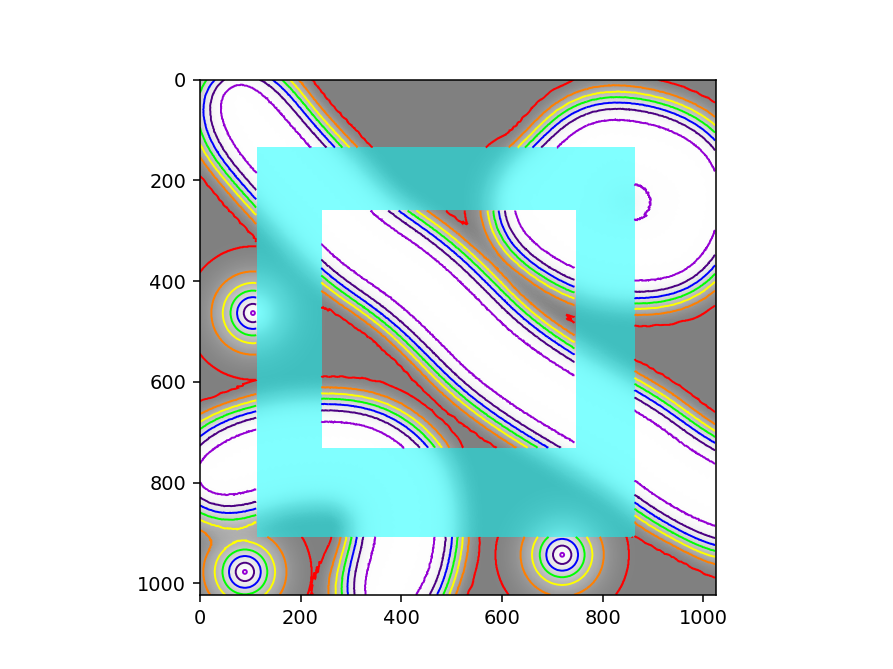

In [28]:
problem = create_test_problem()
marching_square = ThisMarchingSquare(problem.image, problem.mask)
plot_problem(problem, marching_square)

WOS detector (700K pixels)
==========================

In [29]:
problem = create_wos_problem()
print("With mask")
marching_square = MarchingSquareSciKitImage(problem.image, problem.mask)
%timeit [marching_square.iso_contour(a) for a in problem.values]
marching_square = ThisMarchingSquare(problem.image, problem.mask)
%timeit [marching_square.iso_contour(a) for a in problem.values]
print("Without mask")
marching_square = MarchingSquareSciKitImage(problem.image)
%timeit [marching_square.iso_contour(a) for a in problem.values]
marching_square = ThisMarchingSquare(problem.image)
%timeit [marching_square.iso_contour(a) for a in problem.values]

With mask
466 ms ± 14.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
37.8 ms ± 37.5 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
Without mask
133 ms ± 1.13 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
36.5 ms ± 225 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


<IPython.core.display.Javascript object>


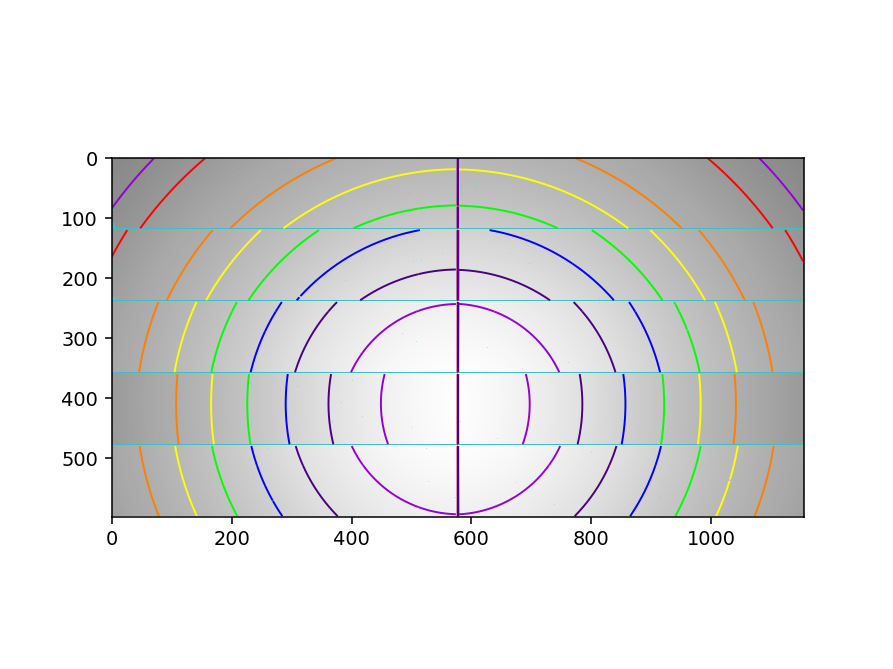

In [30]:
problem = create_wos_problem()
marching_square = ThisMarchingSquare(problem.image, problem.mask)
plot_problem(problem, marching_square)

Perkin Elmer (16M pixels)
===================

In [ ]:
problem = create_id22_17_problem()
print("With mask")
marching_square = MarchingSquareSciKitImage(problem.image, problem.mask)
%timeit [marching_square.iso_contour(a) for a in problem.values]
marching_square = ThisMarchingSquare(problem.image, problem.mask)
%timeit [marching_square.iso_contour(a) for a in problem.values]
marching_square = ThisMarchingSquare(problem.image, problem.mask, use_minmax_cache=True)
%timeit [marching_square.iso_contour(a) for a in problem.values]
print("Without mask")
marching_square = MarchingSquareSciKitImage(problem.image)
%timeit [marching_square.iso_contour(a) for a in problem.values]
marching_square = ThisMarchingSquare(problem.image)
%timeit [marching_square.iso_contour(a) for a in problem.values]
marching_square = ThisMarchingSquare(problem.image, use_minmax_cache=True)
%timeit [marching_square.iso_contour(a) for a in problem.values]

With mask
1.86 s ± 12 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


<IPython.core.display.Javascript object>


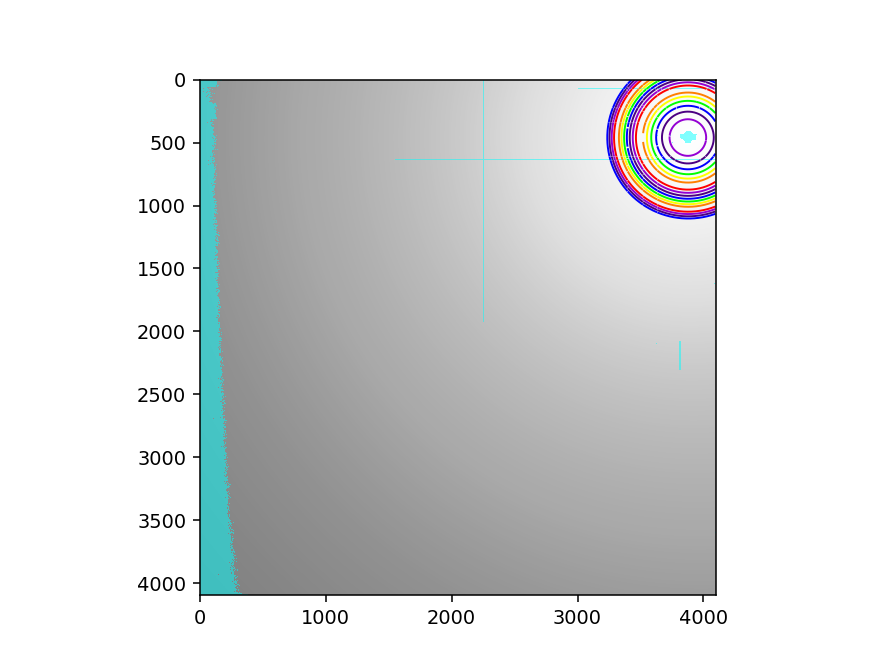

In [15]:
problem = create_id22_17_problem()
marching_square = ThisMarchingSquare(problem.image, problem.mask)
plot_problem(problem, marching_square)